# MANTIS – Supply Chain Mapping AI Module
This notebook implements a proof-of-concept for risk-based supply chain mapping using the dataset generated for military equipment components. It satisfies key Army Design Bureau deliverables related to identifying multi-tier supplier risk, suggesting alternates, and supporting mission-critical readiness.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from datetime import datetime
sns.set(style='whitegrid')

In [2]:
# Load the supply chain mapping dataset
df = pd.read_csv(r"C:\Users\nagan\OneDrive\Desktop\Mantis\data\scm_supplier_data_final.csv")
df.head()

Component_ID        Component_Name  Tier      Supplier_Name  \
0       ALS001  Cooling System - ALS     1  ALS_Solutions_950   
1       ALS001  Cooling System - ALS     1  ALS_Solutions_158   
2       ALS001  Cooling System - ALS     1       ALS_Tech_472   
3       ALS001  Cooling System - ALS     2       ALS_Tech_949   
4       ALS001  Cooling System - ALS     2    ALS_Systems_170   

          Parent_Org Country  %_Ownership Risk_Flag Blocklisted  \
0    Parent_Tech_148     USA           10       Low          No   
1  Parent_Global_784     USA           60       Low          No   
2  Parent_Global_780      UK          100       Low          No   
3    Parent_Tech_643  Russia           80      High         Yes   
4  Parent_Global_587     USA           25       Low          No   

                             Alternate_Suppliers Dependency_Level  \
0                Coo_Global_707; Coo_Systems_977              Low   
1  Coo_Solutions_848; Coo_Tech_673; Coo_Tech_158           Medium   
2                                 Coo_Global_272           Medium   
3         Coo_Industries_978; Coo_Industries_913             High   
4                   Coo_Global_273; Coo_Tech_206              Low   

  Last_Verified  
0    08-11-2024  
1    14-09-2024  
2    30-10-2024  
3    02-02-2025  
4    23-03-2025

In [3]:
# Define risk weights
risk_weights = {'Low': 1, 'Medium': 2, 'High': 3}
dependency_weights = {'Low': 1, 'Medium': 2, 'High': 3}
blocklist_penalty = 2

# Calculate risk index
df['Risk_Score'] = df['Risk_Flag'].map(risk_weights)
df['Blocklist_Score'] = df['Blocklisted'].apply(lambda x: blocklist_penalty if x == 'Yes' else 0)
df['Dependency_Score'] = df['Dependency_Level'].map(dependency_weights)
df['Supplier_Risk_Index'] = (
    0.5 * df['Risk_Score'] +
    0.3 * df['Blocklist_Score'] +
    0.2 * df['Dependency_Score']
)

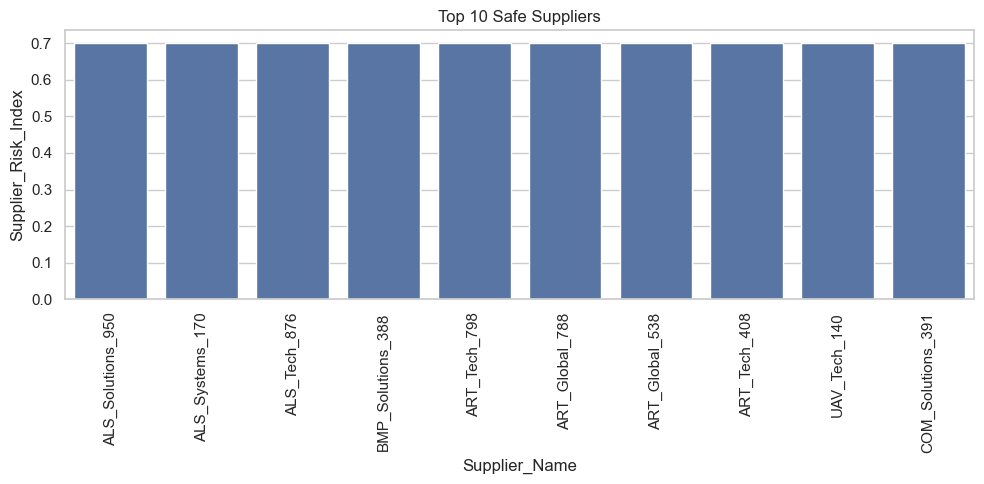

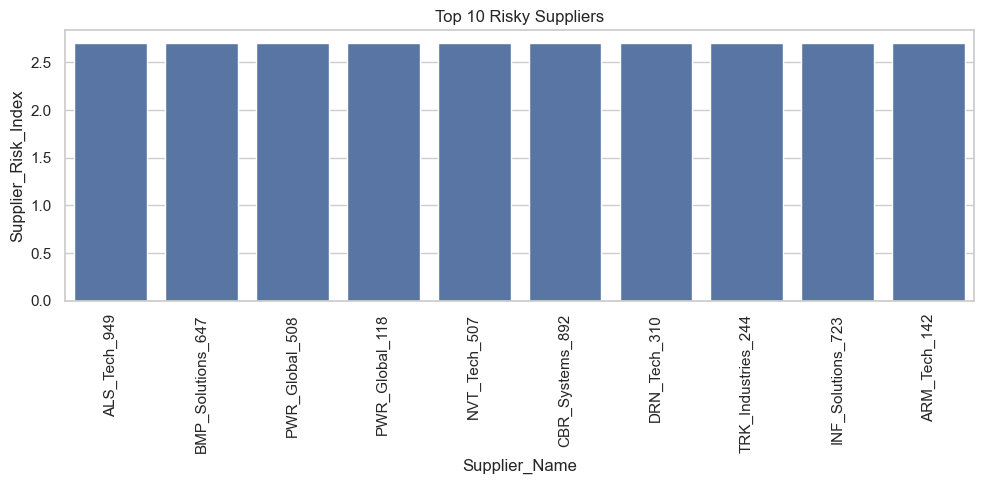

In [4]:
# Plot safest and riskiest suppliers
top_safe = df.sort_values(by='Supplier_Risk_Index').head(10)
top_risky = df.sort_values(by='Supplier_Risk_Index', ascending=False).head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x='Supplier_Name', y='Supplier_Risk_Index', data=top_safe)
plt.title('Top 10 Safe Suppliers')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(x='Supplier_Name', y='Supplier_Risk_Index', data=top_risky)
plt.title('Top 10 Risky Suppliers')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

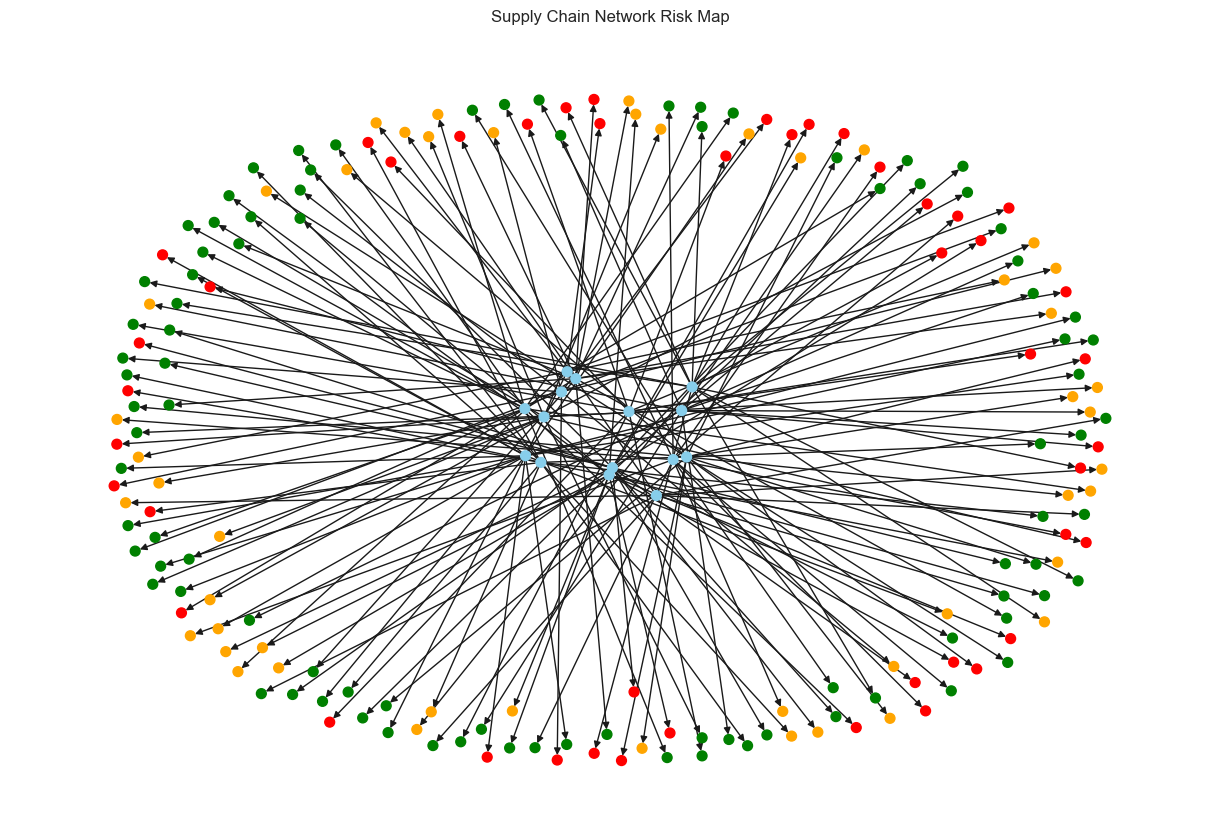

In [5]:
# Create supply chain graph
G = nx.DiGraph()
for _, row in df.iterrows():
    G.add_node(row['Supplier_Name'], risk=row['Risk_Flag'], tier=row['Tier'], component=row['Component_Name'])
    G.add_edge(row['Component_Name'], row['Supplier_Name'])

# Draw graph (simplified)
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.3)
colors = [
    'red' if G.nodes[n].get('risk') == 'High' 
    else 'orange' if G.nodes[n].get('risk') == 'Medium' 
    else 'green' if G.nodes[n].get('risk') == 'Low' 
    else 'skyblue'  # fallback for component root node
    for n in G.nodes()
]
nx.draw(G, pos, node_color=colors, with_labels=False, node_size=50)
plt.title('Supply Chain Network Risk Map')
plt.show()

In [6]:
# Print example of alternate suppliers for a high-risk node
example = df[df['Risk_Flag'] == 'High'].iloc[0]
print('Component:', example['Component_Name'])
print('Tier:', example['Tier'])
print('Current Risky Supplier:', example['Supplier_Name'])
print('Suggested Alternates:', example['Alternate_Suppliers'])

Component: Cooling System - ALS
Tier: 2
Current Risky Supplier: ALS_Tech_949
Suggested Alternates: Coo_Industries_978; Coo_Industries_913


### Graph Supply chain with Risk colouring

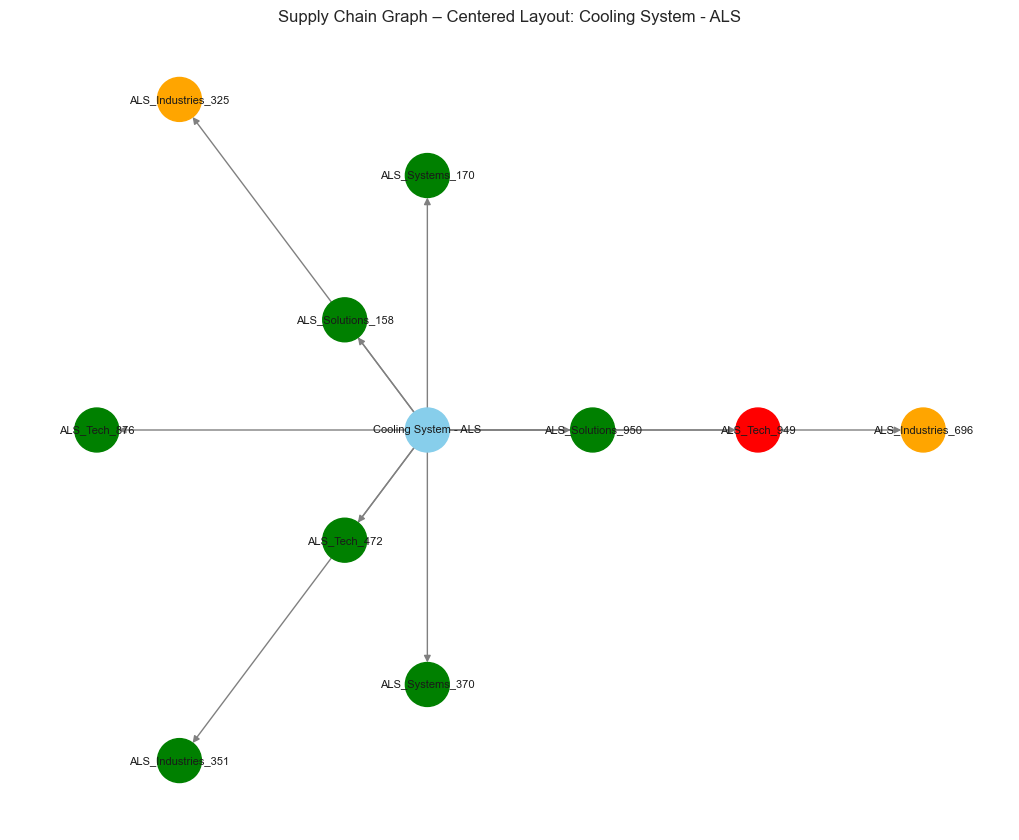

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def plot_supply_chain_graph_centered(component_id, df):
    component_df = df[df["Component_ID"] == component_id]
    G = nx.DiGraph()

    component_name = component_df["Component_Name"].iloc[0]
    G.add_node(component_name, tier=0, risk=None, label=component_name)

    for _, row in component_df.iterrows():
        supplier = row['Supplier_Name']
        tier = row['Tier']
        risk = row['Risk_Flag']  # "Low", "Medium", "High"
        G.add_node(supplier, tier=tier, risk=risk, label=supplier)
        G.add_edge(component_name, supplier)

    # Layout: arrange in concentric rings by tier
    pos = {}
    layers = max([G.nodes[n]['tier'] for n in G.nodes if G.nodes[n]['tier'] != 0] + [1])
    nodes_by_tier = {t: [] for t in range(1, layers+1)}

    pos[component_name] = (0, 0)  # center

    # Arrange each tier in a circle around the center
    for n, attr in G.nodes(data=True):
        if attr['tier'] > 0:
            nodes_by_tier[attr['tier']].append(n)

    for tier, nodes in nodes_by_tier.items():
        radius = 2.5 * tier
        angle_step = 360 / max(len(nodes), 1)
        for i, n in enumerate(nodes):
            angle = i * angle_step
            x = radius * np.cos(np.radians(angle))
            y = radius * np.sin(np.radians(angle))
            pos[n] = (x, y)

    # Node colors
    colors = [
        'red' if G.nodes[n].get('risk') == 'High' else
        'orange' if G.nodes[n].get('risk') == 'Medium' else
        'green' if G.nodes[n].get('risk') == 'Low' else
        'skyblue' for n in G.nodes()
    ]

    labels = {n: G.nodes[n]['label'] for n in G.nodes()}
    
    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, node_color=colors, labels=labels, node_size=1000,
            font_size=8, edge_color='gray', with_labels=True)
    plt.title(f"Supply Chain Graph – Centered Layout: {component_name}")
    plt.axis('off')
    plt.show()

# Example usage
plot_supply_chain_graph_centered("ALS001", df)

### Smart Alternate Supplier Recommender

In [8]:
def recommend_alternate_suppliers(df, risk_threshold=2.0, top_n=3):
    recommendations = []

    risky_suppliers = df[df["Supplier_Risk_Index"] > risk_threshold]

    for _, row in risky_suppliers.iterrows():
        component = row["Component_ID"]
        tier = row["Tier"]
        original = row["Supplier_Name"]
        original_score = row["Supplier_Risk_Index"]

        # Look for same-tier, same-component, non-blocklisted safer suppliers
        candidates = df[
            (df["Component_ID"] == component) &
            (df["Tier"] == tier) &
            (df["Supplier_Name"] != original) &
            (df["Blocklisted"] == "No") &
            (df["Supplier_Risk_Index"] < original_score)
        ].sort_values(by="Supplier_Risk_Index").head(top_n)

        for _, alt in candidates.iterrows():
            recommendations.append({
                "Component": row["Component_Name"],
                "Tier": tier,
                "Original_Supplier": original,
                "Original_Score": round(original_score, 2),
                "Suggested_Alternate": alt["Supplier_Name"],
                "Alternate_Score": round(alt["Supplier_Risk_Index"], 2),
                "Country": alt["Country"],
                "Dependency_Level": alt["Dependency_Level"],
                "Verified_On": alt["Last_Verified"]
            })

    return pd.DataFrame(recommendations)

# Usage
alternate_df = recommend_alternate_suppliers(df, risk_threshold=2.0)
alternate_df.head(10)

Component  Tier   Original_Supplier  \
0                Cooling System - ALS     2        ALS_Tech_949   
1                Cooling System - ALS     2        ALS_Tech_949   
2                Cooling System - ALS     2        ALS_Tech_949   
3             Navigation Unit - BMP-2     2        BMP_Tech_676   
4             Navigation Unit - BMP-2     2   BMP_Solutions_647   
5             Navigation Unit - BMP-2     3   BMP_Solutions_669   
6  Fire Control Processor - Artillery     3   ART_Solutions_333   
7  Fire Control Processor - Artillery     3   ART_Solutions_333   
8  Fire Control Processor - Artillery     3   ART_Solutions_333   
9    Flight Controller - Tactical UAV     2  UAV_Industries_429   

   Original_Score Suggested_Alternate  Alternate_Score      Country  \
0             2.7     ALS_Systems_170              0.7          USA   
1             2.7        ALS_Tech_876              0.7       France   
2             2.7     ALS_Systems_370              0.9      Germany   
3             2.5  BMP_Industries_721              2.1        China   
4             2.7  BMP_Industries_721              2.1        China   
5             2.5   BMP_Solutions_364              1.6       Israel   
6             2.1        ART_Tech_408              0.7       France   
7             2.1   ART_Solutions_980              0.7           UK   
8             2.1  ART_Industries_702              1.1          USA   
9             2.1        UAV_Tech_829              1.2  South Korea   

  Dependency_Level Verified_On  
0              Low  23-03-2025  
1              Low  28-05-2024  
2           Medium  25-01-2025  
3             High  08-08-2024  
4             High  08-08-2024  
5             High  13-11-2024  
6              Low  05-09-2024  
7              Low  26-03-2025  
8             High  04-09-2024  
9              Low  20-05-2024

### Alternate Recommender Visualizer

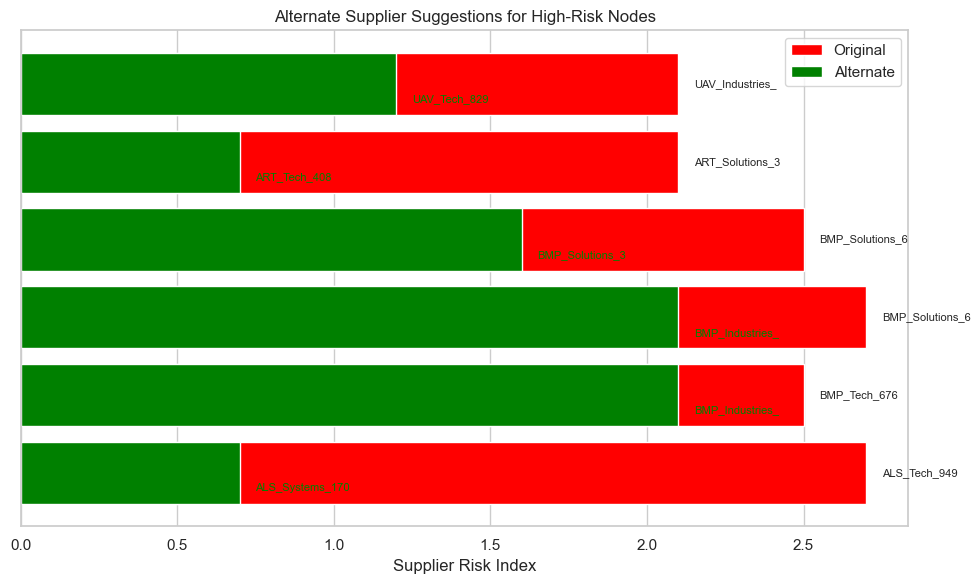

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_alternate_recommendations(alternate_df, top_k=5):
    # Pick top-k original suppliers for visualization
    shown = alternate_df.groupby("Original_Supplier").head(1).head(top_k)

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, (_, row) in enumerate(shown.iterrows()):
        ax.barh(i, row["Original_Score"], color='red', label='Original' if i == 0 else "")
        ax.barh(i, row["Alternate_Score"], color='green', left=0, label='Alternate' if i == 0 else "")
        ax.text(row["Original_Score"] + 0.05, i, f'{row["Original_Supplier"][:15]}', va='center', fontsize=8)
        ax.text(row["Alternate_Score"] + 0.05, i - 0.2, f'{row["Suggested_Alternate"][:15]}', va='center', fontsize=8, color='green')

    ax.set_yticks([])
    ax.set_xlabel("Supplier Risk Index")
    ax.set_title("Alternate Supplier Suggestions for High-Risk Nodes")
    ax.legend()
    plt.tight_layout()
    plt.show()

# Run after alternate_df is created
plot_alternate_recommendations(alternate_df, top_k=6)

### Convert SCM CSV → JSON (Nodes + Edges)

In [10]:
import pandas as pd
import json

def generate_scm_graph_json(csv_path, json_path="scm_graph.json"):
    df = pd.read_csv(csv_path)

    # Generate unique supplier IDs if missing
    if "Supplier_ID" not in df.columns:
        df["Supplier_ID"] = df["Component_ID"].astype(str) + "_" + df["Tier"].astype(str) + "_" + df["Supplier_Name"].astype(str)

    # Node format
    nodes = []
    seen_nodes = set()
    for _, row in df.iterrows():
        node_id = row["Supplier_ID"]
        if node_id not in seen_nodes:
            nodes.append({
                "id": node_id,
                "label": row["Supplier_Name"],
                "component": row["Component_ID"],
                "tier": row["Tier"],
                "country": row.get("Country", ""),
                "risk": row.get("Risk_Flag", "Unknown"),
                "blocklisted": row.get("Blocklisted", "No")
            })
            seen_nodes.add(node_id)

    # Edge format (skip Tier 1 with no parent)
    edges = []
    if "Parent_Supplier_ID" in df.columns:
        for _, row in df.iterrows():
            if pd.notna(row["Parent_Supplier_ID"]):
                edges.append({
                    "from": row["Parent_Supplier_ID"],
                    "to": row["Supplier_ID"],
                    "component": row["Component_ID"]
                })

    graph_data = {
        "nodes": nodes,
        "edges": edges
    }

    with open(json_path, "w") as f:
        json.dump(graph_data, f, indent=2)

    print(f"✅ Graph JSON saved to: {json_path}")

# Example usage:
generate_scm_graph_json(r"C:\Users\nagan\OneDrive\Desktop\Mantis\data\scm_supplier_data_final.csv", "scm_network_graph.json")


✅ Graph JSON saved to: scm_network_graph.json
